In [1]:
import numpy as np
import pandas as pd
#
from sklearn.impute import SimpleImputer
from collections import Counter

#시각화
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import xgboost as xgb
from xgboost import plot_importance
#scaling
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler


#
# pip install imblearn #imblearn 설치
from imblearn.combine import *
from imblearn.combine import SMOTETomek

#warning messages
import warnings
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv('train.csv', encoding = 'cp949').set_index('custid')
test = pd.read_csv('test.csv', encoding = 'cp949').set_index('custid')

In [3]:
print(train.shape) # train = 5000 sample, 17 feature / custid' 제외
print(test.shape) # test = 5000 sample, 16 feature / 'custid' 제외

(5000, 17)
(5000, 16)


In [4]:
df = train.copy()

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 18 to 49993
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   gender     5000 non-null   int64  
 1   총구매액       5000 non-null   int64  
 2   구매건수       5000 non-null   int64  
 3   평균구매가격     5000 non-null   int64  
 4   평균할부개월수    5000 non-null   float64
 5   구매브랜드종류    5000 non-null   int64  
 6   내점일수       5000 non-null   int64  
 7   수입상품_구매비율  5000 non-null   float64
 8   주말방문비율     5000 non-null   float64
 9   가을_구매건수    4055 non-null   float64
 10  겨울_구매건수    4103 non-null   float64
 11  봄_구매건수     4311 non-null   float64
 12  여름_구매건수    3978 non-null   float64
 13  아침_구매건수    3558 non-null   float64
 14  저녁_구매건수    4033 non-null   float64
 15  점심_구매건수    4855 non-null   float64
 16  주구매코너      5000 non-null   object 
dtypes: float64(10), int64(6), object(1)
memory usage: 703.1+ KB


In [ ]:
#all_features = pd.concat((train.iloc[:,1:], test.iloc[:,0:])) #gender 제외

In [ ]:
#all_features.shape

In [ ]:
#all_features.info()

In [ ]:
#중복 데이터 확인 ----> 중복데이터 없음
#train_dup = all_features.reset_index()
#train_dup = train_dup['custid'].duplicated()
#train_dup.value_counts()

#### object type 변환

In [10]:
df.loc[(df['주구매코너'] == '영캐주얼') |
       (df['주구매코너'] == '피혁A') |
       (df['주구매코너'] == '유니캐주얼') |
       (df['주구매코너'] == '니트단품') |
       (df['주구매코너'] == '섬유') |
       (df['주구매코너'] == '캐릭터캐주얼') |
       (df['주구매코너'] == '피혁B') |
       (df['주구매코너'] == '엘레강스캐주얼') |
       (df['주구매코너'] == '트래디셔널캐주얼') |
       (df['주구매코너'] == '유아동복') |
       (df['주구매코너'] == '정장셔츠') |
       (df['주구매코너'] == '타운모피'), '코너분류'] = '패션'
        
df.loc[(df['주구매코너'] == '일반식품'), '코너분류'] = '식품'
        
df.loc[(df['주구매코너'] == '가전') |
       (df['주구매코너'] == '조리욕실') |
       (df['주구매코너'] == '가구') |
       (df['주구매코너'] == '도자기크리스탈') |
       (df['주구매코너'] == '침구수예'), '코너분류'] = '생활'
        
df.loc[(df['주구매코너'] == '수입명품') |
       (df['주구매코너'] == '디자이너부띠끄'), '코너분류'] = '고급'
        
df.loc[(df['주구매코너'] == '화장품') |
       (df['주구매코너'] == '스포츠') |
       (df['주구매코너'] == '장신구'), '코너분류'] = '잡화'

df.loc[(df['주구매코너'] == '문화완구') |
       (df['주구매코너'] == '기타바이어'), '코너분류'] = '기타'

In [11]:
df.head()

,gender,총구매액,구매건수,평균구매가격,평균할부개월수,구매브랜드종류,내점일수,수입상품_구매비율,주말방문비율,가을_구매건수,겨울_구매건수,봄_구매건수,여름_구매건수,아침_구매건수,저녁_구매건수,점심_구매건수,주구매코너,코너분류
custid,,,,,,,,,,,,,,,,,,
18,0,680100,15,45340,1.7,9,10,26.7,100.0,NaN,9.0,6.0,NaN,NaN,6.0,9.0,화장품,잡화
21,0,353450,9,39272,1.2,6,8,11.1,37.5,NaN,5.0,4.0,NaN,3.0,NaN,6.0,영캐주얼,패션
23,0,5671400,36,157539,2.8,22,16,5.6,37.5,7.0,17.0,12.0,NaN,10.0,11.0,15.0,장신구,잡화
26,0,1964000,28,70143,1.4,15,14,39.3,28.6,5.0,8.0,15.0,NaN,NaN,18.0,10.0,화장품,잡화
35,0,885000,5,177000,6.0,5,2,0.0,100.0,NaN,NaN,5.0,NaN,NaN,5.0,NaN,피혁A,패션


In [14]:
df['주구매코너'].value_counts()

일반식품        1306
화장품         1206
유니캐주얼        410
유아동복         383
스포츠          301
영캐주얼         246
캐릭터캐주얼       188
수입명품         136
섬유            96
니트단품          91
트래디셔널캐주얼      91
정장셔츠          90
엘레강스캐주얼       78
피혁A           75
장신구           68
피혁B           56
디자이너부띠끄       51
문화완구          38
조리욕실          28
가전            18
기타바이어         12
도자기크리스탈       11
침구수예           8
가구             7
타운모피           6
Name: 주구매코너, dtype: int64

In [15]:
#내점구매율 추가
df['내점구매율'] = np.round(df['구매건수'] /df['내점일수'], 2)
df.head()

,gender,총구매액,구매건수,평균구매가격,평균할부개월수,구매브랜드종류,내점일수,수입상품_구매비율,주말방문비율,가을_구매건수,겨울_구매건수,봄_구매건수,여름_구매건수,아침_구매건수,저녁_구매건수,점심_구매건수,주구매코너,코너분류,내점구매율
custid,,,,,,,,,,,,,,,,,,,
18,0,680100,15,45340,1.7,9,10,26.7,100.0,NaN,9.0,6.0,NaN,NaN,6.0,9.0,화장품,잡화,1.50
21,0,353450,9,39272,1.2,6,8,11.1,37.5,NaN,5.0,4.0,NaN,3.0,NaN,6.0,영캐주얼,패션,1.12
23,0,5671400,36,157539,2.8,22,16,5.6,37.5,7.0,17.0,12.0,NaN,10.0,11.0,15.0,장신구,잡화,2.25
26,0,1964000,28,70143,1.4,15,14,39.3,28.6,5.0,8.0,15.0,NaN,NaN,18.0,10.0,화장품,잡화,2.00
35,0,885000,5,177000,6.0,5,2,0.0,100.0,NaN,NaN,5.0,NaN,NaN,5.0,NaN,피혁A,패션,2.50


In [16]:
obj = df.dtypes[df.dtypes == 'object'].index
num = df.dtypes[df.dtypes != 'object'].index

In [ ]:
df[obj] = df[obj].apply(lambda x: x.astype('category').cat.codes)

In [ ]:
df.head()

In [17]:
df.isnull().sum()

gender          0
총구매액            0
구매건수            0
평균구매가격          0
평균할부개월수         0
구매브랜드종류         0
내점일수            0
수입상품_구매비율       0
주말방문비율          0
가을_구매건수       945
겨울_구매건수       897
봄_구매건수        689
여름_구매건수      1022
아침_구매건수      1442
저녁_구매건수       967
점심_구매건수       145
주구매코너           0
코너분류            0
내점구매율           0
dtype: int64

In [18]:
#null 값 있는 컬럼
null_col = df.iloc[:,9:-3]
null_col = null_col.columns

In [19]:
df[null_col].head()

,가을_구매건수,겨울_구매건수,봄_구매건수,여름_구매건수,아침_구매건수,저녁_구매건수,점심_구매건수
custid,,,,,,,
18,NaN,9.0,6.0,NaN,NaN,6.0,9.0
21,NaN,5.0,4.0,NaN,3.0,NaN,6.0
23,7.0,17.0,12.0,NaN,10.0,11.0,15.0
26,5.0,8.0,15.0,NaN,NaN,18.0,10.0
35,NaN,NaN,5.0,NaN,NaN,5.0,NaN


In [ ]:
#all_features['사계절 합'] = all_features.iloc[:,8:12].sum(axis=1)
#all_features['일일 합'] = all_features.iloc[:,12:15].sum(axis=1)
#all_features.head()
#all_features = all_features.drop('구매건수 차', axis=1)
#all_features['구매건수 차'] = all_features['구매건수'] - all_features['일일 합']
#all_features['구매건수 차'].value_counts()

In [20]:
#null 값 -> 0 입력
df[null_col] = df[null_col].fillna(0)
df.isnull().sum()

gender       0
총구매액         0
구매건수         0
평균구매가격       0
평균할부개월수      0
구매브랜드종류      0
내점일수         0
수입상품_구매비율    0
주말방문비율       0
가을_구매건수      0
겨울_구매건수      0
봄_구매건수       0
여름_구매건수      0
아침_구매건수      0
저녁_구매건수      0
점심_구매건수      0
주구매코너        0
코너분류         0
내점구매율        0
dtype: int64

In [21]:
df = pd.get_dummies(df, dummy_na=True)
df.shape

(5000, 50)

In [22]:
df.head(3)

,gender,총구매액,구매건수,평균구매가격,평균할부개월수,구매브랜드종류,내점일수,수입상품_구매비율,주말방문비율,가을_구매건수,...,주구매코너_피혁B,주구매코너_화장품,주구매코너_nan,코너분류_고급,코너분류_기타,코너분류_생활,코너분류_식품,코너분류_잡화,코너분류_패션,코너분류_nan
custid,,,,,,,,,,,,,,,,,,,,,
18,0,680100,15,45340,1.7,9,10,26.7,100.0,0.0,...,0,1,0,0,0,0,0,1,0,0
21,0,353450,9,39272,1.2,6,8,11.1,37.5,0.0,...,0,0,0,0,0,0,0,0,1,0
23,0,5671400,36,157539,2.8,22,16,5.6,37.5,7.0,...,0,0,0,0,0,0,0,1,0,0


#참고 https://ko.d2l.ai/chapter_deep-learning-basics/kaggle-house-price.html

#check skewness
- 참고 https://www.kaggle.com/fkstepz/step-by-step-predict-bike-sharing-demand

In [23]:
from sklearn.preprocessing import LabelEncoder
from scipy import stats
from scipy.stats import norm, skew 

In [24]:
num

Index(['gender', '총구매액', '구매건수', '평균구매가격', '평균할부개월수', '구매브랜드종류', '내점일수',
       '수입상품_구매비율', '주말방문비율', '가을_구매건수', '겨울_구매건수', '봄_구매건수', '여름_구매건수',
       '아침_구매건수', '저녁_구매건수', '점심_구매건수', '내점구매율'],
      dtype='object')

In [25]:
skewed_f = df[num].apply(lambda x: skew(x.dropna ())
                                ).sort_values(ascending = False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' : skewed_f})
skewness


Skew in numerical features: 



,Skew
총구매액,5.781570
아침_구매건수,4.917130
저녁_구매건수,4.482165
점심_구매건수,3.610048
평균구매가격,3.148305
여름_구매건수,3.123849
구매건수,3.059414
내점일수,3.011361
가을_구매건수,2.983893
봄_구매건수,2.797174


In [26]:
skewness = skewness[abs(skewness) > 0]
skewness

,Skew
총구매액,5.781570
아침_구매건수,4.917130
저녁_구매건수,4.482165
점심_구매건수,3.610048
평균구매가격,3.148305
여름_구매건수,3.123849
구매건수,3.059414
내점일수,3.011361
가을_구매건수,2.983893
봄_구매건수,2.797174


In [27]:
#수치형 변수의 왜도, 첨도 확인
for col in num:
    print('{:15}'.format(col),
          'Skewness: {:05.2f}'.format(df[col].skew()),
          '      ',
          'Kurtosis: {:06.2f}'.format(df[col].kurt()))

gender          Skewness: 00.85        Kurtosis: -01.28
총구매액            Skewness: 05.78        Kurtosis: 060.23
구매건수            Skewness: 03.06        Kurtosis: 015.61
평균구매가격          Skewness: 03.15        Kurtosis: 016.48
평균할부개월수         Skewness: 02.27        Kurtosis: 012.85
구매브랜드종류         Skewness: 01.74        Kurtosis: 004.58
내점일수            Skewness: 03.01        Kurtosis: 015.62
수입상품_구매비율       Skewness: 02.11        Kurtosis: 005.37
주말방문비율          Skewness: 00.63        Kurtosis: 000.17
가을_구매건수         Skewness: 02.98        Kurtosis: 014.64
겨울_구매건수         Skewness: 02.73        Kurtosis: 011.73
봄_구매건수          Skewness: 02.80        Kurtosis: 012.21
여름_구매건수         Skewness: 03.12        Kurtosis: 016.05
아침_구매건수         Skewness: 04.92        Kurtosis: 040.45
저녁_구매건수         Skewness: 04.48        Kurtosis: 033.04
점심_구매건수         Skewness: 03.61        Kurtosis: 023.48
내점구매율           Skewness: 01.42        Kurtosis: 004.00


<AxesSubplot:xlabel='총구매액', ylabel='Density'>

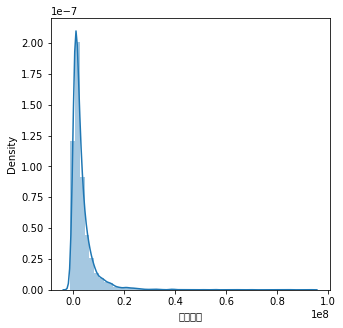

In [28]:
#왜도, 첨도 시각적 확인
f, ax = plt.subplots(figsize=(5,5))
sns.distplot(df['총구매액'])

Skewness: -0.403897
Kurtosis: 0.167335


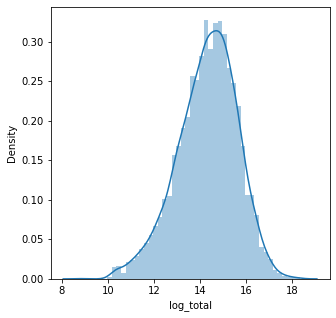

In [30]:
df['log_total'] = np.log1p(df['총구매액'])
f, ax = plt.subplots(figsize = (5,5))
sns.distplot(df['log_total'])
print('Skewness: {:3f}'.format(df['log_total'].skew()))
print('Kurtosis: {:3f}'.format(df['log_total'].kurt()))
#{: 숫자f} 숫자만큼의 공백 

<AxesSubplot:xlabel='아침_구매건수', ylabel='Density'>

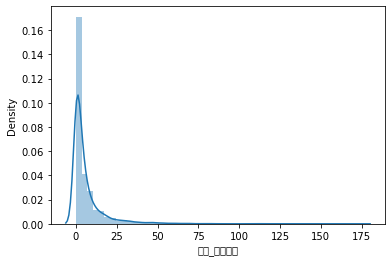

In [29]:
sns.distplot(df['아침_구매건수'])

Skewness: 0.519595
Kurtosis: -0.545618


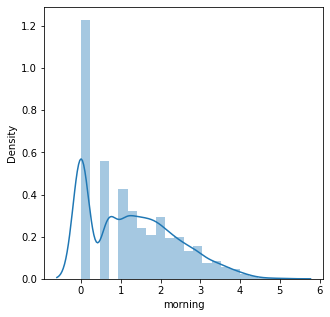

In [31]:
df['morning'] = np.log1p(df['아침_구매건수'])
f, ax = plt.subplots(figsize = (5,5))
sns.distplot(df['morning'])
print('Skewness: {:3f}'.format(df['morning'].skew()))
print('Kurtosis: {:3f}'.format(df['morning'].kurt()))

##Log를 취해준 변수의 
- Skewness와 Kurtosis가 많이 떨어짐 (왜도, 첨도)
- plot 자체도 나름 정규 근사화가 된 것 확인 - '총구매액'



출처: https://hong-yp-ml-records.tistory.com/28 [HONG YP's Data Science BLOG]

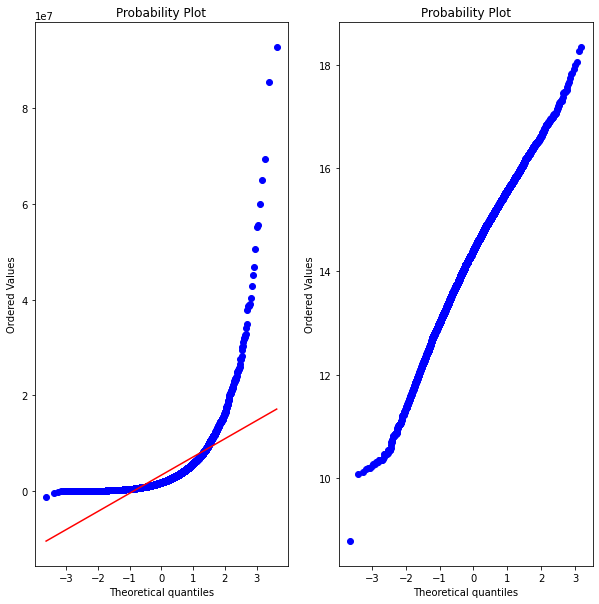

In [32]:
from scipy import stats
fig = plt.figure(figsize = (10,10))
fig.add_subplot(1,2,1)
res = stats.probplot(df['총구매액'],plot=plt)

fig.add_subplot(1,2,2)
res = stats.probplot(df['log_total'],plot=plt)
## 그래프상 휘어짐이 줄었음 -> 정규분포에 가까운 ???

In [ ]:
df.head()

array([[<AxesSubplot:title={'center':'gender'}>,
        <AxesSubplot:title={'center':'총구매액'}>,
        <AxesSubplot:title={'center':'구매건수'}>,
        <AxesSubplot:title={'center':'평균구매가격'}>,
        <AxesSubplot:title={'center':'평균할부개월수'}>,
        <AxesSubplot:title={'center':'구매브랜드종류'}>,
        <AxesSubplot:title={'center':'내점일수'}>],
       [<AxesSubplot:title={'center':'수입상품_구매비율'}>,
        <AxesSubplot:title={'center':'주말방문비율'}>,
        <AxesSubplot:title={'center':'가을_구매건수'}>,
        <AxesSubplot:title={'center':'겨울_구매건수'}>,
        <AxesSubplot:title={'center':'봄_구매건수'}>,
        <AxesSubplot:title={'center':'여름_구매건수'}>,
        <AxesSubplot:title={'center':'아침_구매건수'}>],
       [<AxesSubplot:title={'center':'저녁_구매건수'}>,
        <AxesSubplot:title={'center':'점심_구매건수'}>,
        <AxesSubplot:title={'center':'내점구매율'}>,
        <AxesSubplot:title={'center':'주구매코너_가구'}>,
        <AxesSubplot:title={'center':'주구매코너_가전'}>,
        <AxesSubplot:title={'center':'주구매코너_기타바이어'}>,
     

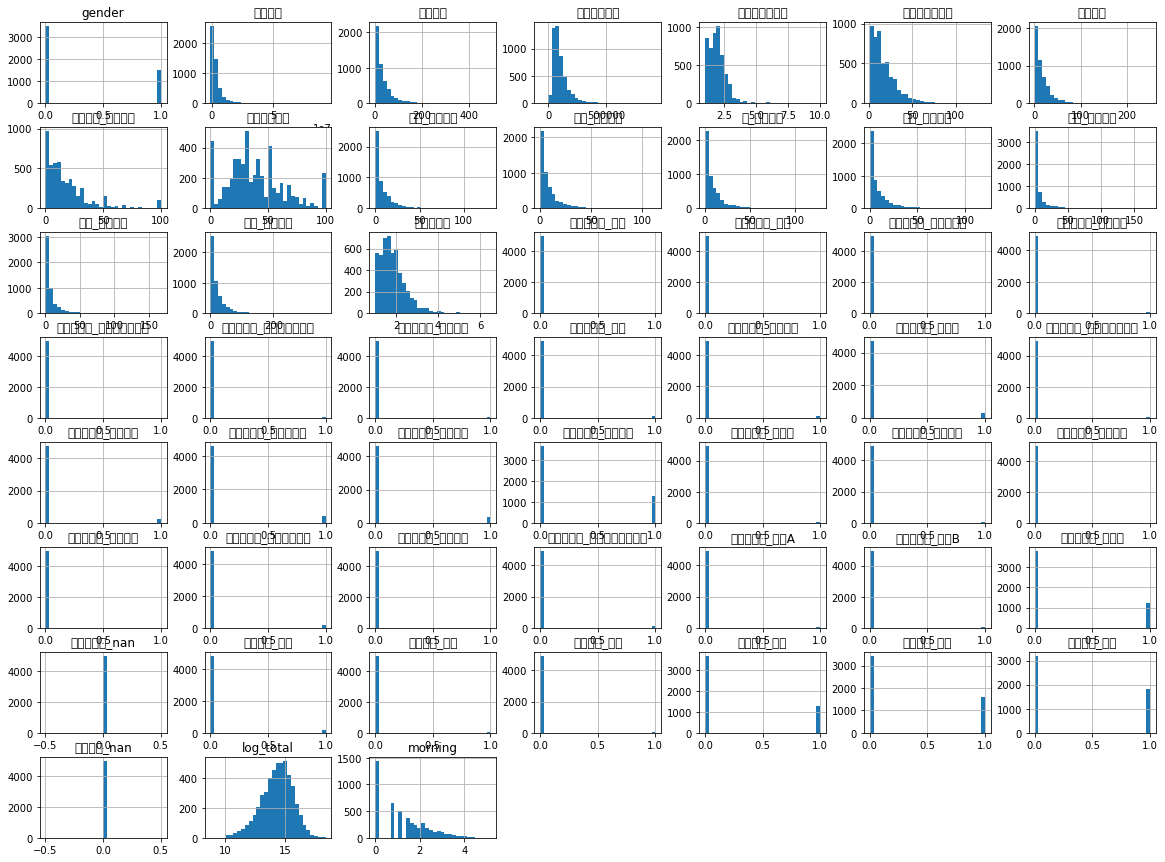

In [33]:
df.hist(bins=30, figsize=(20,15))

In [ ]:
corr=df.corr()
mask = np.array(corr)
mask[np.tril_indices_from(mask)] = False
fig, ax = plt.subplots(figsize=(20,10))
sns.heatmap(corr, mask=mask, vmax=1.,annot=True)

## 참고 사이트
# https://www.kaggle.com/fkstepz/step-by-step-predict-bike-sharing-demand

In [ ]:
# 전처리한 결과를 CSV파일로 보존
df.to_csv('h-df.csv', index=False)

In [ ]:
#언더샘플링
import numpy as np
from imblearn.under_sampling import RandomUnderSampler

In [ ]:
df['gender'].value_counts()

In [ ]:
df.info()

In [ ]:
df['log_total'].value_counts()

In [ ]:
df['log_total'].fillna(df['log_total'].mean(), inplace=True)

In [ ]:
# 데이터 세트를 설명변수와 목적변수로 분할
X = np.array(df.drop('gender', axis=1))
Y = np.array(df['gender'])

# y가 1또는 0인 데이터의 건수를 카운트
print(np.sum(Y == 1), np.sum(Y == 0))

# y가 1인 데이터의 건수에 맞춰서 다운사이징
sampler = RandomUnderSampler(random_state=42)
X, Y = sampler.fit_resample(X, Y)

# y가 1또는 0인 데이터의 건수를 카운트
print(np.sum(Y == 1), np.sum(Y == 0))

#K-검정

In [ ]:
from sklearn.feature_selection import SelectKBest

# 특징량을 n개 선택
selector = SelectKBest(k=8) 
selector.fit(X, Y)
mask = selector.get_support()

# 어느 변수를 선택하였는지 확인
print(df.drop('gender', axis=1).columns)
print(mask)

In [ ]:
df['gender'].value_counts()

In [ ]:
#훈련세트, 테스트세트 나누기
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(all_features, test_size = 0.3)

In [ ]:
train_set.shape
test_set.shape